In [1]:
# Instalación de librerías necesarias
!pip install yfinance scikit-learn --quiet


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [20]:
# Descargar datos desde Yahoo Finance
ticker = 'META'
start_date = '2020-01-01'
end_date = '2024-12-31'

df = yf.download(ticker, start=start_date, end=end_date)
full_df= yf.download(ticker, start='2019-01-01', end='2024-12-31')
# Verificar columnas disponibles
print("Columnas disponibles:", df.columns)

# Usar 'Adj Close' si está disponible, si no usar 'Close'
if 'Adj Close' in df.columns:
    df = df[['Adj Close']].copy()
    df.rename(columns={'Adj Close': 'Price'}, inplace=True)
elif 'Close' in df.columns:
    df = df[['Close']].copy()
    df.rename(columns={'Close': 'Price'}, inplace=True)
else:
    raise ValueError("No se encontró ni 'Adj Close' ni 'Close' en los datos descargados.")

# Re-sampleo semanal y cálculo de variables
df['Return'] = df['Price'].pct_change()
df['Volatility'] = df['Return'].rolling(window=10).std()
df['MA20'] = df['Price'].rolling(window=20).mean()

# Eliminar nulos
df.dropna(inplace=True)

# Re-muestrear a datos semanales (usando cierre del viernes)
weekly_df = df.resample('W-FRI').last()

# Variables objetivo: Precio de la semana siguiente
weekly_df['Target'] = weekly_df['Price'].shift(-1)
weekly_df.dropna(inplace=True)

# Dividir en entrenamiento (2020-2023) y test (2024)
df_train = weekly_df[weekly_df.index.year < 2024]
df_real_2024 = weekly_df[weekly_df.index.year == 2024]

# Selección de variables
features = ['Return', 'Volatility', 'MA20']
X_train = df_train[features]
y_train = df_train['Target']
X_test = df_real_2024[features]
y_test = df_real_2024['Target']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Columnas disponibles: MultiIndex([( 'Close', 'META'),
            (  'High', 'META'),
            (   'Low', 'META'),
            (  'Open', 'META'),
            ('Volume', 'META')],
           names=['Price', 'Ticker'])


In [ ]:
# Ingeniería de características y división ya realizadas en la celda anterior.

In [ ]:
# Preparación de datos ya realizada en la celda anterior.

In [21]:
# Entrenamiento del modelo Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

MAE (error absoluto medio): 161.8737
RMSE (raíz del error cuadrático medio): 171.2482


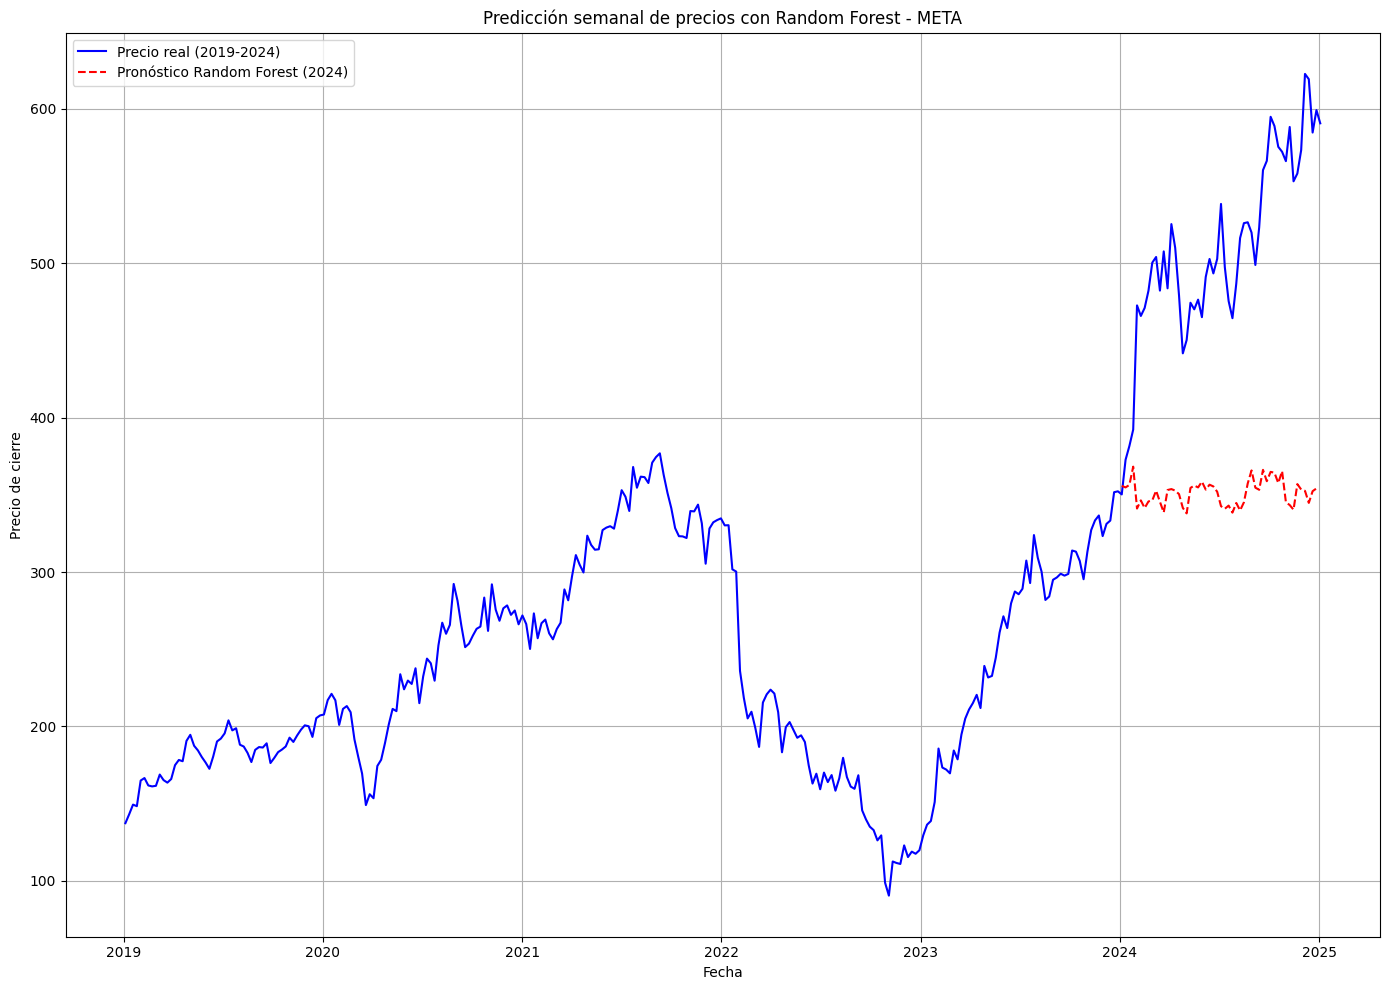

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predicción del modelo
pronostico_2024= rf.predict(X_test)

# Cálculo de métricas
mae = mean_absolute_error(y_test, pronostico_2024)
rmse = np.sqrt(mean_squared_error(y_test, pronostico_2024))

print(f'MAE (error absoluto medio): {mae:.4f}')
print(f'RMSE (raíz del error cuadrático medio): {rmse:.4f}')



# Usar columna válida
if 'Adj Close' in full_df.columns:
    full_df = full_df[['Adj Close']].copy()
    full_df.rename(columns={'Adj Close': 'Price'}, inplace=True)
elif 'Close' in full_df.columns:
    full_df = full_df[['Close']].copy()
    full_df.rename(columns={'Close': 'Price'}, inplace=True)
else:
    raise ValueError("No se encontró ni 'Adj Close' ni 'Close'.")

# Re-muestreo semanal (viernes)
full_weekly = full_df.resample('W-FRI').last()

# --- Visualización detallada ---

plt.figure(figsize=(14, 10))
plt.plot(full_weekly.index, full_weekly['Price'], label='Precio real (2019-2024)', color='blue')
plt.plot(y_test.index, pronostico_2024, label='Pronóstico Random Forest (2024)', color='red', linestyle='--')
plt.title(f'Predicción semanal de precios con Random Forest - {ticker}')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
